## Librerias

In [1]:
# Tratamiento de datos
# ============================================================================
import pandas as pd
import numpy as np
import datetime

# Gráficos
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Modelado y Forescasting
# ============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración de warnings
# ============================================================================
import warnings
warnings.filterwarnings('ignore')


## Exploracion de datos

In [7]:
url = 'https://raw.githubusercontent.com/ronalcabrera/PG_Olist/main/Semana2/Datasets_procesados/'

sellers = pd.read_csv(url+'sellers.csv')

products = pd.read_csv(url+'products.csv')

orders = pd.read_csv(url+'orders.csv')
orders.order_purchase_timestamp=pd.to_datetime(orders.order_purchase_timestamp, format='%Y-%m-%dT')
orders.order_delivered_customer_date=pd.to_datetime(orders.order_delivered_customer_date, format='%Y-%m-%dT')
orders.order_estimated_delivery_date=pd.to_datetime(orders.order_estimated_delivery_date, format='%Y-%m-%dT')
orders['tiempo_trans_total'] = (orders.order_delivered_customer_date - orders.order_purchase_timestamp).dt.days
orders['tiempo_demora'] = (orders.order_delivered_customer_date - orders.order_estimated_delivery_date).dt.days
#orders.order_purchase_timestamp=orders.order_purchase_timestamp.dt.date

order_items = pd.read_csv(url+'order_items.csv')
order_items['price_total'] = order_items['price'].values + order_items['freight_value'].values

order_reviews = pd.read_csv(url+'order_reviews.csv')

order_payments = pd.read_csv(url+'order_payments.csv')
closed_deals = pd.read_csv(url+'closed_deals.csv')
customers = pd.read_csv(url+'customers.csv')
marketing_qualified_leads = pd.read_csv(url+'marketing_qualified_leads.csv')
zip_code_prefix = pd.read_csv(url+'zip_code_prefix.csv')

df= order_items[['id_order','id_product','id_seller','price_total']].merge(
    sellers[['id_seller','id_code_prefix']]).merge(
    products[['id_product','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]).merge(
    orders[['id_order','id_customer','order_purchase_timestamp','order_status','tiempo_trans_total','tiempo_demora']]).merge(
    order_reviews[['id_order','review_score']]).merge(
    customers[['id_customer','id_code_prefix']])

# Tomo los datos que voy a usar, 2016= 366 ventas / 2017 = 49876 ventas / 2018 = 60531 ventas
datos = df[['product_name_lenght','product_description_lenght','product_photos_qty','order_purchase_timestamp']].groupby(
            ['order_purchase_timestamp']).mean()

# Agrego cantidad de ventas
datos['cantidad_ventas'] = df[['product_photos_qty','order_purchase_timestamp']].groupby(['order_purchase_timestamp']).count().values

# Armo el dataframe en intervalos de a 1 hora
datos = datos.resample(rule='H', closed='left', label='right').mean()

# Creo variable que indica si es fin de semana
datos['dia_semana'] = datos.index.dayofweek
datos = pd.get_dummies(datos, columns=['dia_semana'])
datos = datos.fillna(0)

# Agrego columna vacaciones para los dias festivos inamobibles: https://www.datosmundial.com/america/brasil/dias-festivos.php
datos['holidays']=  np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==4)&(datos.reset_index()['order_purchase_timestamp'].dt.day==21),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==4)&(datos.reset_index()['order_purchase_timestamp'].dt.day==23),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==5)&(datos.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==6)&(datos.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==7)&(datos.reset_index()['order_purchase_timestamp'].dt.day==9),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==8)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==8)&(datos.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==9)&(datos.reset_index()['order_purchase_timestamp'].dt.day==7),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==2),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==24),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==26),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==31),1,
                    0)))))))))))))))))))))

datos = datos[['product_name_lenght','product_description_lenght','product_photos_qty','holidays',
                'dia_semana_0','dia_semana_1','dia_semana_2','dia_semana_3','dia_semana_4',
                'dia_semana_5','dia_semana_6','cantidad_ventas']]

datos.head(5)

,product_name_lenght,product_description_lenght,product_photos_qty,holidays,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,cantidad_ventas
order_purchase_timestamp,,,,,,,,,,,,
2017-01-13 16:00:00,57.0,983.0,2.0,0,0,0,0,0,1,0,0,1.0
2017-01-13 17:00:00,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0
2017-01-13 18:00:00,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0
2017-01-13 19:00:00,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0
2017-01-13 20:00:00,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0.0


In [19]:
# Separo los datos entrenamiento - validacion - test
# ============================================================================
fin_train = '2018-03-31 23:00:00' 
fin_validacion = '2018-06-30 23:00:00'
fin_test = '2018-08-31 23:00:00' # No se toma en cuenta Septiembre por inconsistencias en los datos.

datos_train = datos.loc[:fin_train,:] # 19 meses
datos_val = datos.loc[fin_train:fin_validacion,:] # 3 meses
datos_test = datos.loc[fin_validacion:fin_test,:] # 2 meses

print(f"Fechas train        : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validación   : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test         : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train        : 2016-09-04 22:00:00 --- 2018-03-31 23:00:00  (n=13754)
Fechas validación   : 2018-03-31 23:00:00 --- 2018-06-30 23:00:00  (n=2185)
Fechas test         : 2018-06-30 23:00:00 --- 2018-08-31 23:00:00  (n=1489)


## Exploración gráfica

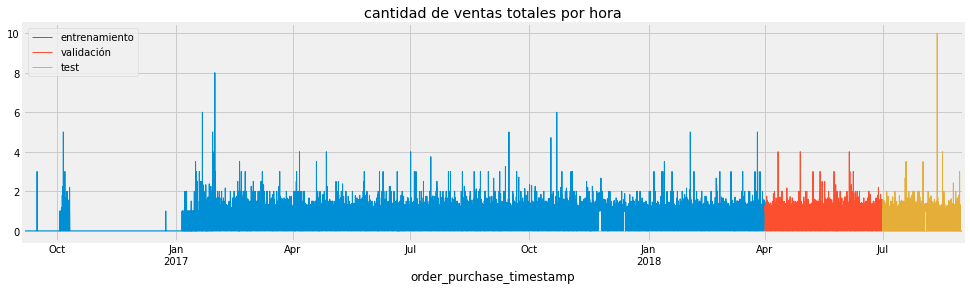

In [20]:
# Gráfica de la serie temporal
# ============================================================================
fig, ax = plt.subplots(figsize=(15,4))
datos_train.cantidad_ventas.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.cantidad_ventas.plot(ax=ax, label='validación', linewidth=1)
datos_test.cantidad_ventas.plot(ax=ax, label='test', linewidth=1)
ax.set_title('cantidad de ventas totales por hora')
ax.legend();

In [22]:
# Gráfica interactivo de la serie temporal
# ============================================================================
datos.loc[:fin_train, 'partition'] = 'train'
datos.loc[fin_train:fin_validacion, 'partition'] = 'validation'
datos.loc[fin_validacion:fin_test, 'partition'] = 'test'

fig = px.line(
    data_frame  = datos.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = 'cantidad_ventas',
    color       = 'partition',
    title       = 'Numero de ventas totales',
    width       = 1200,
    height      = 580
)
fig.show()
datos=datos.drop(columns='partition')

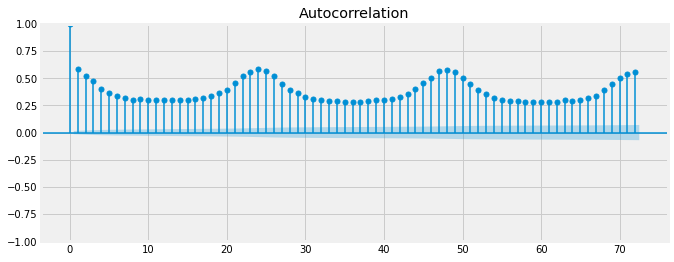

In [23]:
# Gráfica de autocorrelación
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(datos.cantidad_ventas, ax=ax, lags=72)
plt.show()

Podemos observar en el gráfico que hay una directa correlación entre lo que pasa un día respecto a lo que pasó el día anterior a la misma hora

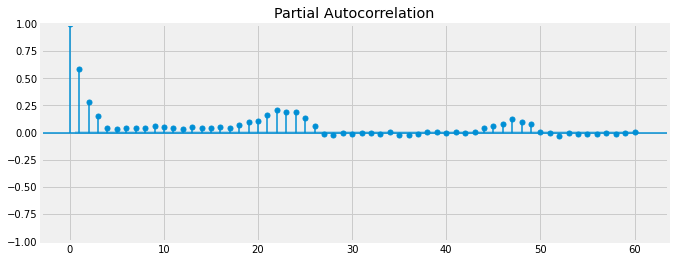

In [24]:
# Gráfica de autocorrelación parcial
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(datos.cantidad_ventas, ax=ax, lags=60)
plt.show()

Text(0, 0.5, 'Festivo')

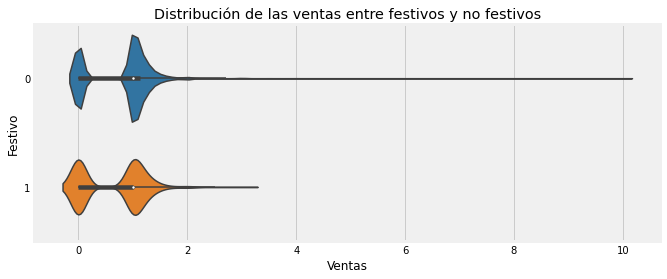

In [25]:
# Días festivos vs laborales
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(
    x       = 'cantidad_ventas',
    y       = 'holidays',
    data    = datos.assign(holidays=datos.holidays.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de las ventas entre festivos y no festivos')
ax.set_xlabel('Ventas')
ax.set_ylabel('Festivo')

Se observa un mayor volumen de ventas en los días no festivos

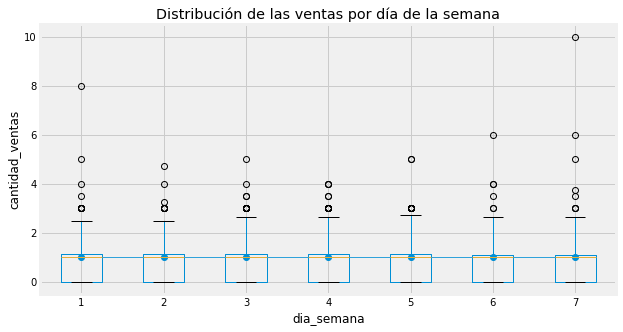

In [13]:
# Gráfico boxplot para estacionalidad semanal
# ============================================================================
fig, ax = plt.subplots(figsize=(10,5))
datos['dia_semana']=datos.index.day_of_week + 1
datos.boxplot(column='cantidad_ventas', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['cantidad_ventas'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('cantidad_ventas')
ax.set_title('Distribución de las ventas por día de la semana')
fig.suptitle('');

Las ventas se distribuyen de forma equitativa a lo largo de la semana, no hay ninguna diferencia apreciable en cuanto a ello.

## Modelado

In [26]:
# Creo y entreno forecaster
# ============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                lags      = 24
            )
forecaster #forecaster.summary()


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-26 12:13:57 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [27]:
# Entreno el modelo
# ============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'cantidad_ventas']) # Entrenamiento con conjuntos de train y validación
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-09-04 22:00:00'), Timestamp('2018-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-26 12:13:57 
Last fi

## Predicción

In [28]:
predicciones = forecaster.predict(steps=24)
predicciones

2018-07-01 00:00:00    1.140173
2018-07-01 01:00:00    1.037302
2018-07-01 02:00:00    0.807510
2018-07-01 03:00:00    0.631932
2018-07-01 04:00:00    0.643845
2018-07-01 05:00:00    0.849840
2018-07-01 06:00:00    0.742931
2018-07-01 07:00:00    1.031204
2018-07-01 08:00:00    1.070979
2018-07-01 09:00:00    1.113244
2018-07-01 10:00:00    1.163325
2018-07-01 11:00:00    1.169668
2018-07-01 12:00:00    1.169668
2018-07-01 13:00:00    1.163078
2018-07-01 14:00:00    1.155587
2018-07-01 15:00:00    1.147256
2018-07-01 16:00:00    1.141790
2018-07-01 17:00:00    1.154236
2018-07-01 18:00:00    1.157202
2018-07-01 19:00:00    1.144757
2018-07-01 20:00:00    1.141790
2018-07-01 21:00:00    1.156711
2018-07-01 22:00:00    1.170926
2018-07-01 23:00:00    1.160579
Freq: H, Name: pred, dtype: float64

In [29]:
# Plot de predicciones interactivas
# ============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['cantidad_ventas'],
                'prediction': predicciones,
            })
datos_plot.index.name= 'order_purchase_timestamp'

fig = px.line(
    data_frame  = datos_plot.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = datos_plot.columns,
    title       = 'Ventas totales',
    width       = 1200,
    height      = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting

In [30]:
# Backtest
# ============================================================================
metrica, predicciones = backtesting_forecaster(
                                forecaster=forecaster,
                                y=datos['cantidad_ventas'],
                                initial_train_size=len(datos.loc[:fin_validacion]),
                                steps=24,
                                metric='mean_absolute_error',
                                refit=False,
                                verbose=True
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 15938
Number of observations used for backtesting: 1547
    Number of folds: 65
    Number of steps per fold: 24
    Last fold only includes 11 observations.

Data partition in fold: 0
    Training:   2016-09-04 22:00:00 -- 2018-06-30 23:00:00  (n=15938)
    Validation: 2018-07-01 00:00:00 -- 2018-07-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2016-09-04 22:00:00 -- 2018-06-30 23:00:00  (n=15938)
    Validation: 2018-07-02 00:00:00 -- 2018-07-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2016-09-04 22:00:00 -- 2018-06-30 23:00:00  (n=15938)
    Validation: 2018-07-03 00:00:00 -- 2018-07-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2016-09-04 22:00:00 -- 2018-06-30 23:00:00  (n=15938)
    Validation: 2018-07-04 00:00:00 -- 2018-07-04 23:00:00  (n=24)
Data partition in fold: 4
    Training:   2016-09-04 22:00:00 -- 2018

In [31]:
print(f'Backtest error: {metrica}')

Backtest error: 0.2750354538270188


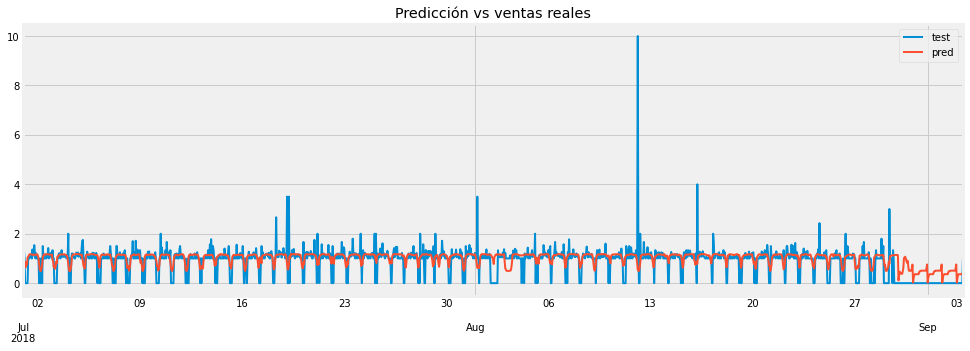

In [32]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index, 'cantidad_ventas'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='prediccion', ax=ax)
ax.set_title('Predicción vs ventas reales')
ax.legend();

In [35]:
# Plot de predicciones interactivas
# ============================================================================
datos_plot=pd.DataFrame({
                'test': datos_test['cantidad_ventas'],
                'prediction': predicciones['pred'],
})
datos_plot.index.name='order_purchase_timestamp'

fig = px.line(
    data_frame  = datos_plot.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = datos_plot.columns,
    title       = 'Ventas totales',
    width       = 1200,
    height      = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Optimizacion de parámetros

In [45]:
# Grid_search de hiperparámetros
# ============================================================================
# Hiperparámetros del regresor
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 10],
    'learning_rate': [0.01, 0.1]
}
# Lags utulizados como predictores
lags_grid = [24, 48, [1, 2, 24]]

resultados_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = datos.loc[:fin_validacion, 'cantidad_ventas'], # conjunto de train y validacion
                    param_grid          = param_grid,
                    lags_grid           = lags_grid,
                    steps               = 24,
                    refit               = False,
                    metric              = 'mean_absolute_error',
                    initial_train_size  = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
                    return_best         = True,
                    verbose             = False
                )

Number of models compared: 24.


loop lags_grid:   0%|                                               | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid:  33%|█████████████                          | 1/3 [00:03<00:06,  3.47s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid:  67%|██████████████████████████             | 2/3 [00:07<00:03,  3.77s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:10<00:00,  3.44s/it]


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 0.2298013461181836



In [46]:
# Resultados de grid_search
# ============================================================================
resultados_grid.head(10)

,lags,params,mean_absolute_error,learning_rate,max_depth,max_iter
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.229801,0.01,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",0.232467,0.01,3.0,500.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.233110,0.10,3.0,100.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.234481,0.10,10.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.237045,0.10,3.0,500.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.241739,0.10,10.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.241819,0.01,10.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.242770,0.10,10.0,100.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",0.242959,0.01,3.0,500.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.243881,0.10,3.0,100.0


In [47]:
# Backtest con nuevos hiperparámetros
# ============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster          = forecaster,
    y                   = datos.cantidad_ventas,
    initial_train_size  = len(datos.loc[:fin_validacion]),
    steps               = 24,
    metric              = 'mean_absolute_error',
    refit               = False,
    verbose             = False
)
print(f'Backtest error: {metrica}')

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
Backtest error: 0.2626089987151778


Ahora agrego otras variables , llamadas variables exógenas, para mejorar la predicción

In [48]:
# Backtest con nuevos hiperparámetros
# ============================================================================
forecaster = ForecasterAutoreg(
                regressor=LGBMRegressor(max_depth=3, learning_rate=0.1, n_estimators=100),
                lags=48
            )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-26 14:15:15 
Last fit date: None 

In [49]:
variables_exog = ['holidays','dia_semana_0','dia_semana_1','dia_semana_2',
                'dia_semana_3','dia_semana_4','dia_semana_5','dia_semana_6']
forecaster.fit(
    y=datos.loc[:fin_validacion, 'cantidad_ventas'],
    exog=datos.loc[:fin_validacion, variables_exog]
    )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['holidays', 'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5', 'dia_semana_6'] 
Training range: [Timestamp('2016-09-04 22:00:00'), Timestamp('2018-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31,

In [50]:
# Predicción
# ============================================================================
exog_siguientes_24h = datos_test[variables_exog][:24]

predicciones = forecaster.predict(steps=24, exog=exog_siguientes_24h)
predicciones

2018-07-01 00:00:00    1.095366
2018-07-01 01:00:00    1.028951
2018-07-01 02:00:00    0.850173
2018-07-01 03:00:00    0.742368
2018-07-01 04:00:00    0.375698
2018-07-01 05:00:00    0.650516
2018-07-01 06:00:00    0.856474
2018-07-01 07:00:00    0.900224
2018-07-01 08:00:00    1.092794
2018-07-01 09:00:00    1.136840
2018-07-01 10:00:00    1.136045
2018-07-01 11:00:00    1.121064
2018-07-01 12:00:00    1.152848
2018-07-01 13:00:00    1.151424
2018-07-01 14:00:00    1.162576
2018-07-01 15:00:00    1.147642
2018-07-01 16:00:00    1.133865
2018-07-01 17:00:00    1.115419
2018-07-01 18:00:00    1.116410
2018-07-01 19:00:00    1.116015
2018-07-01 20:00:00    1.122645
2018-07-01 21:00:00    1.130328
2018-07-01 22:00:00    1.104402
2018-07-01 23:00:00    1.135459
Freq: H, Name: pred, dtype: float64

In [51]:
# Backtest
# ============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster=forecaster,
                            y=datos['cantidad_ventas'],
                            exog=datos[variables_exog],
                            initial_train_size=len(datos.loc[:fin_validacion]),
                            steps=24,
                            metric='mean_absolute_error',
                            refit=False,
                            verbose=False
                        )
metrica

0.26155634617775886

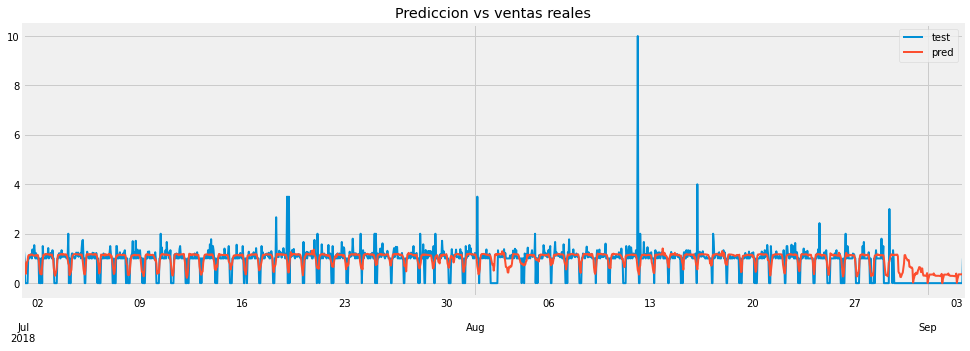

In [52]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index, 'cantidad_ventas'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2,label='prediccion', ax=ax)
ax.set_title('Prediccion vs ventas reales')
ax.legend();

Ahora con el modelo ya entrenado, hago la predicción sobre los ultimos meses del 2018 a partir de septiembre

In [70]:
# Predicción
# ============================================================================

#Primero creo el dataframe con el que hago la predicción
start = datetime.datetime.strptime("31-08-2018", "%d-%m-%Y")
end = datetime.datetime.strptime("01-01-2019", "%d-%m-%Y")
date_generated = pd.date_range(start, end)

df_predict = pd.DataFrame()
df_predict['order_purchase_timestamp'] = date_generated
df_predict = df_predict.set_index('order_purchase_timestamp')
# Armo el dataframe en intervalos de a 1 hora
df_predict = df_predict.resample(rule='H', closed='left', label='right').mean()

# Agrego columna vacaciones para los dias festivos inamobibles: https://www.datosmundial.com/america/brasil/dias-festivos.php
df_predict['holidays']=  np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==4)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==21),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==4)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==23),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==5)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==6)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==7)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==9),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==8)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==8)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==9)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==7),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==2),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==24),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==26),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==31),1,
                    0)))))))))))))))))))))

# Creo variable que indica si es fin de semana
df_predict['dia_semana'] = df_predict.index.dayofweek
df_predict = pd.get_dummies(df_predict, columns=['dia_semana'])
df_predict = df_predict.fillna(0)

# Creo una ventana de las ultima 48hs para empezar a predecir en septiembre
datos_ultimas_48hs = datos.loc['29-08-2018 00:00:00':'31-08-2018 23:00:00', 'cantidad_ventas']

predicciones = forecaster.predict(steps=2953, exog=df_predict, last_window=datos_ultimas_48hs)
predicciones

2018-09-01 00:00:00    0.011045
2018-09-01 01:00:00    0.167758
2018-09-01 02:00:00    0.252307
2018-09-01 03:00:00    0.355809
2018-09-01 04:00:00    0.355809
                         ...   
2019-01-01 20:00:00    1.148639
2019-01-01 21:00:00    1.153232
2019-01-01 22:00:00    1.153232
2019-01-01 23:00:00    1.153232
2019-01-02 00:00:00    1.153232
Freq: H, Name: pred, Length: 2953, dtype: float64

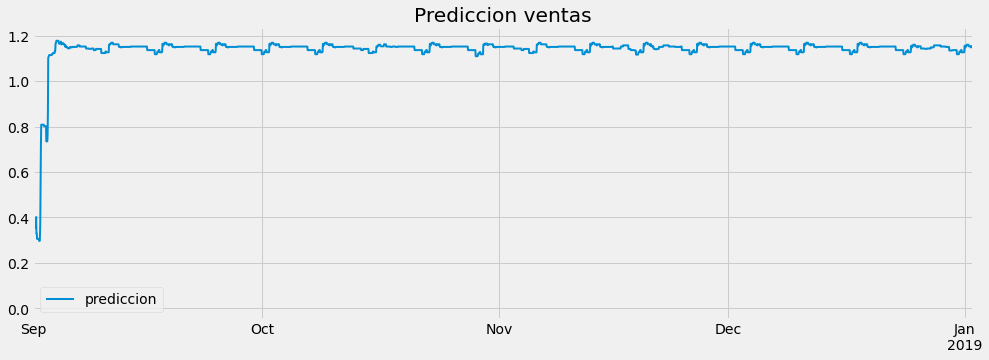

In [71]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
predicciones.plot(linewidth=2,label='prediccion', ax=ax)
ax.set_title('Prediccion ventas')
ax.legend();

In [74]:
predicciones.to_csv('predicciones')